In [3]:
#import Libraries
import os
import time
import math
import random
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from keras.models import Sequential
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, InputLayer, Reshape
from keras.preprocessing.image import ImageDataGenerator, load_img
import time
import math
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import np_utils
from keras.utils import plot_model
from keras.callbacks import History 
from keras.datasets.mnist import load_data
from keras.utils import to_categorical
from keras.optimizers import adam
from sklearn.model_selection import train_test_split
from keras import optimizers

%matplotlib inline

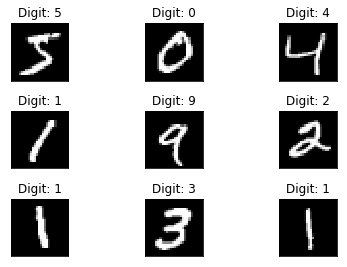

In [4]:
#Load the dataset

(train_digits, train_labels), (test_digits, test_labels) = load_data()
train_digits.shape, train_labels.shape, test_digits.shape, test_labels.shape

#let us see what our data look like
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(train_digits[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(train_labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
#reshape 
X_train = np.reshape(train_digits, newshape=(60000, 28*28))
y_train = train_labels
X_test = test_digits
X_test.shape
y_test = test_labels


In [6]:
classes = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
#num_classes =10
img_size = 28


In [7]:
#split train set to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=101)

C:\Users\rhasan\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)
print ("X_validation", X_val.shape)
print ("y_validation", y_val.shape)
# building the input vector from the 28x28 pixels
#X_train = X_train.reshape(60000, 784)
#X_test = X_test.reshape(10000, 784)
X_train = X_train.reshape((-1, 28,28, 1))
X_val = X_val.reshape((-1, 28,28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
# normalizing the data to help with the training
X_train /= 255
X_test /= 255
X_val /= 255
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)
print ("validation matrix shape", X_val.shape)

X_train shape (54000, 784)
y_train shape (54000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
X_validation (6000, 784)
y_validation (6000,)
Train matrix shape (54000, 28, 28, 1)
Test matrix shape (10000, 28, 28, 1)
validation matrix shape (6000, 28, 28, 1)


In [9]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train,num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test= keras.utils.to_categorical(y_test,num_classes)
y_train.shape, y_val.shape, y_test.shape


((54000, 10), (6000, 10), (10000, 10))

In [10]:
#helper function to dig into our training progress
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [11]:
# helper function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
   
    print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt ='d'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


    np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=classes,
                      title='Confusion matrix')

# Plot normalized confusion matrix
    #plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                     # title='Normalized confusion matrix')

    
    plt.show()


In [12]:
'''#Build out MLP model using keras-sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()'''


"#Build out MLP model using keras-sequential model\nmodel = Sequential()\nmodel.add(Dense(512, input_shape=(784,)))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(512, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(num_classes, activation='softmax'))\n\nmodel.summary()"

In [16]:

#BUILD YOUR CNN
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(28, 28, 1), name="test"))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))


# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(512, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               803328    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total para

0 layer_conv1
1 max_pooling2d_3
2 layer_conv2
3 max_pooling2d_4
4 flatten_2
5 dense_3
6 dense_4


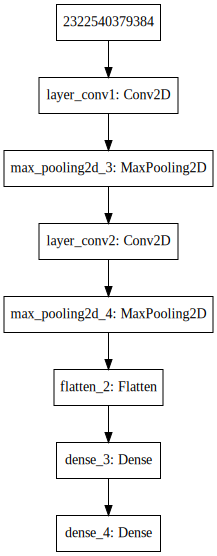

In [17]:
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model, to_file='model.png')

import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model

def visualize_model(model):
  # check the layers by name
  for i,layer in enumerate(model.layers):
      print(i,layer.name)
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
visualize_model(model)


Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 7s 129us/step - loss: 2.2992 - acc: 0.1198 - val_loss: 2.2937 - val_acc: 0.1452
Epoch 2/3
54000/54000 [==============================] - 4s 73us/step - loss: 2.2875 - acc: 0.1634 - val_loss: 2.2821 - val_acc: 0.1798
Epoch 3/3
54000/54000 [==============================] - 4s 76us/step - loss: 2.2758 - acc: 0.1903 - val_loss: 2.2702 - val_acc: 0.1973


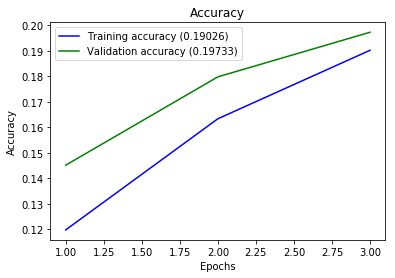

In [18]:
#train our model
history = History()
opt = optimizers.SGD(lr=0.0001, decay=1e-6)
epochs = 3
batch_size = 50

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))


					
plot_history(history)					

In [20]:
#evaluate our model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05747337624002248
Test accuracy: 0.9818


In [21]:
#print classification accuracy
print("{0}: {1:.2%}".format(model.metrics_names[1], score[1]))


acc: 98.18%


In [22]:
# the predicted class
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis=1)

# the true class 
y_true = test_labels

Confusion matrix
[[ 973    0    6    0    1    2    3    2    4    5]
 [   0 1125    4    0    0    0    2    1    1    7]
 [   1    3 1009    3    1    0    0   12    4    0]
 [   0    2    1  998    0    3    1    2    3    7]
 [   0    0    3    0  967    0    1    3    3    6]
 [   1    0    0    3    0  880    2    0    2    5]
 [   1    2    0    0    2    3  946    0    1    0]
 [   1    0    4    2    3    1    0 1001    5    5]
 [   3    3    5    4    2    2    3    2  947    2]
 [   0    0    0    0    6    1    0    5    4  972]]


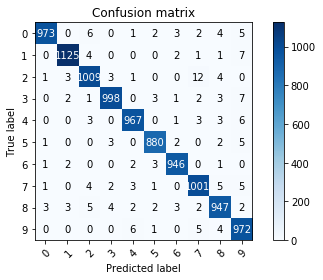

In [23]:
plot_confusion_matrix(y_pred, y_true, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

In [24]:
##evaluate incorrectly classified examples
cls_pred = model.predict_classes(X_test) #the predicted class label for each test sample

# see the number of samples predicted correctly
correct = np.nonzero(cls_pred == test_labels)[0]
incorrect = np.nonzero(cls_pred != test_labels)[0]
print()
print(len(correct)," classified correctly")
print(len(incorrect)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)
fig_evaluation = plt.figure()
# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(cls_pred[incorrect], 
                                       test_labels[incorrect]))
    plt.xticks([])
    plt.yticks([])




9818  classified correctly
182  classified incorrectly


#TO DO
#add two convolutional layers followed by two max-pooling layers of size 3. 
#use ADAM optimizer with learning rate 0.0001 # https://keras.io/optimizers/
#add more neurons to the first fully-connected layer
#use KERAS DOCUMENTATION for more info
#https://keras.io/